# Predicting a Biological Response 
# Boehringer Ingelheim
# Mónica Tatiana Gutierrez Ballen
# Maestría en Ingeniería de la Información
# Universidad de los Andes 
# 24 de Junio del 2018

## Descripción del proyecto

El objetivo de la competencia es ayudar a construir el mejor modelo posible para que se pueda, tan óptimamente como lo permitan estos datos, relacionar la información molecular, con una respuesta biológica real. La "respuesta biológica" es un término genérico que significa que se observa un cambio en los organismos debido a la presencia de las moléculas.

Cada fila de la base de datos en este conjunto de datos representa una molécula. La primera columna contiene datos experimentales que describen una respuesta biológica real; se vio que la molécula provocaba esta respuesta (1), o no (0). Las columnas restantes representan descriptores moleculares (d1 a d1776), estas son propiedades calculadas que pueden capturar algunas de las características de la molécula, por ejemplo, tamaño, forma o constitución elemental. La matriz del descriptor se ha normalizado. Contiene un total de 1777 variables y 3751 columnas. 

La selección del proyecto está en la categoría **"Featured"** y el premio que ofrecían era de **\$20,000**

In [1]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
import pandas as pd
import numpy as np
import sklearn as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
# Next line to silence pyflakes. This import is needed.
Axes3D

Automatically created module for IPython interactive environment


mpl_toolkits.mplot3d.axes3d.Axes3D

In [2]:
train = pd.io.parsers.read_table('Benchmark/train.csv', sep=',')
test = pd.io.parsers.read_table('Benchmark/test.csv', sep=',')

In [3]:
train.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Preparación de los datos

La base no contiene datos faltantes para ninguna de las variables. Debido a que los datos obtenidos hacen referencia a medidas (variables numéricas),por ende, no se hace ningún tipo de combinación o eliminación de variables. Sin embargo, posteriormente se realizan análisis para reducción de la dimensionalidad.

In [4]:
train.dtypes

Activity      int64
D1          float64
D2          float64
D3          float64
D4          float64
D5          float64
D6          float64
D7          float64
D8          float64
D9          float64
D10         float64
D11         float64
D12         float64
D13         float64
D14         float64
D15         float64
D16         float64
D17         float64
D18         float64
D19         float64
D20         float64
D21         float64
D22         float64
D23           int64
D24         float64
D25         float64
D26         float64
D27           int64
D28           int64
D29         float64
             ...   
D1747         int64
D1748         int64
D1749         int64
D1750         int64
D1751         int64
D1752         int64
D1753         int64
D1754         int64
D1755         int64
D1756         int64
D1757         int64
D1758         int64
D1759         int64
D1760         int64
D1761         int64
D1762         int64
D1763         int64
D1764         int64
D1765         int64


In [5]:
train.shape

(3751, 1777)

In [6]:
# drop rows with any missing values
train.dropna().shape

(3751, 1777)

In [7]:
train.shape

(3751, 1777)

Se realiza la partición de la base, donde la variable **Y** hace referencia a la actividad de la molecula y las variables **X** son las otras variables que componen cada descriptor molecular.

In [8]:
X = train.iloc[:,1:1777]
Y = train.Activity

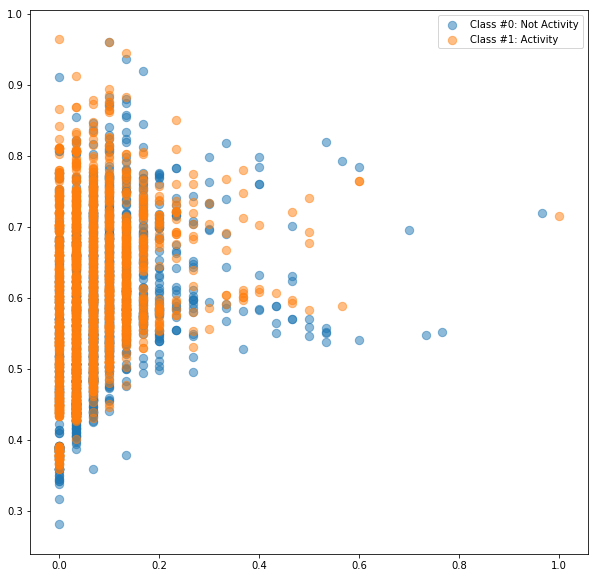

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Plot the two classes
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0: Not Activity", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1: Activity", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

plot_two_classes(X.values, Y)

Se puede observar que la distribución de las categorías está cargada hacia la categoría 1 (Actividad molecular) y muy pocos datos atípicos. Sin embargo, por el contexto del problema, se recomienda no eliminar estos datos atípicos ya que puede tener una influencia importante en el modelo. 

## Reducción de la dimensionalidad y elección de los modelos

Debido a que la base de datos contiene muchas variables (una proporción del 47% respecto a las filas), se plantea hacer una reducción de la dimensionalidad, probando 4 métodos: PCA, Isomap, Locally-Linear Embedding) LLE, Local tangent space alignment (LTSA) y Modified Locally-Linear Embedding (MLLE). Éstas 3 últimas son técnicas de reducción de dimensionalidad no linear. El objetivo es probar cada una de ellas para ver como se comporta con un modelo sencillo (Regresión Logística) basados en la pérdida logarítmica (relacionada con la entropía cruzada), la cual mide el rendimiento de un modelo de clasificación donde la entrada de predicción es un valor de probabilidad entre 0 y 1. El objetivo de nuestros modelos de aprendizaje automático es minimizar este valor. Un modelo perfecto tendría una pérdida de registro de 0. La pérdida de registro aumenta a medida que la probabilidad prevista diverge de la categoría real. Además, se utiliza el método de K Fold Cross Validation para la calibración de los modelos. 

Posteriormente, seleccionado el método de reducción de dimensionalidad, se hace una verificación de desbalanceo de la base y se procede a probar los siguientes algoritmos de clasificación:

* Regresión logística
* Árboles de decisión
* Naive Bayes
* Random Forest 
* Ensamble

### Regresión logística K fold

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

kf = KFold(X.shape[0], n_folds=10, random_state=666)

results = []

for train_index, test_index in kf:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # train a logistic regression model
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)

    # make predictions for testing set
    y_pred_class = logreg.predict(X_test)

    # calculate testing accuracy
    results.append(log_loss(y_test, y_pred_class))

print('Mean',pd.Series(results).mean())
print('Std',pd.Series(results).std() )
    

Mean 10.202358235752323
Std 0.6389427398660124


En esta primera estimación se utiliza la base tal como está (sin reducción)y se puede observar que el Log Loss es de 10,2. Este será el criterio para seleccionar el método de reducción de dimensionalidad. 

### Descomposición PCA 

0.9819462471153997


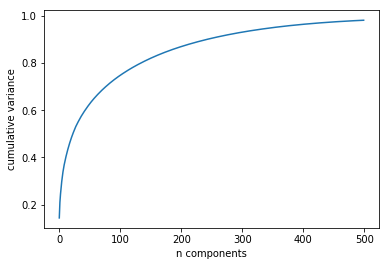

In [12]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 500)
# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit(X)
print(x_vis.explained_variance_ratio_.sum())
plt.plot(np.cumsum(x_vis.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

En éste gráfico se puede observar que la varianza acumulada tiene un crecimiento rápido, en donde a las 500 componentes principales se obtiene el 98% de la información total de los datos. La experiencia estadística dicta que recolectar un 75% de la información es un buen criterio para obtener una explicación óptima de la información. Por ende se seleccionan 100 componentes, y también servirá como criterio para calcular la reducción de dimensionalidad en los métodos no lineares.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100,random_state= 666)
# Fit and transform x to visualise inside a 2D feature space
Redu_PCA = pca.fit(X)
print(Redu_PCA.explained_variance_ratio_.sum())

0.7464634459584172


In [15]:
X_transform = pca.fit_transform(X)

### Regresión logística con descomposición PCA

In [20]:
from sklearn.cross_validation import KFold

kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

results = []

for train_index, test_index in kf:
    X_train, X_test = X_transform[train_index], X_transform[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # train a logistic regression model
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)

    # make predictions for testing set
    y_pred_class = logreg.predict(X_test)

    # calculate testing accuracy
    results.append(log_loss(y_test, y_pred_class))

print('Mean',pd.Series(results).mean())
print('Std',pd.Series(results).std() )


Mean 8.443688041947532
Std 0.5897581081494246


Al realizar la estimación de la regresión logística con el método PCA, se encuentra que utilizando 100 componentes es suficiente para reducir notablemente el Log loss, pasando de 10,20 (utilizando todas las variables) a 8,44, es decir que este método puede ser una buena opción para minimizar la perdida logarítmica.

## Descomposición por Isomap

In [21]:
from sklearn.manifold import Isomap
t0=time()
for components in [3,5,10,15,20,30,40,50,100,150,200,500]:
    Redu_isomap = Isomap(n_components=components)
    X_transform = Redu_isomap.fit_transform(X)
    kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

    results = []

    for train_index, test_index in kf:
        X_train, X_test = X_transform[train_index], X_transform[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # train a logistic regression model
        logreg = LogisticRegression(C=1e9)
        logreg.fit(X_train, y_train)

        # make predictions for testing set
        y_pred_class = logreg.predict(X_test)

        # calculate testing accuracy
        results.append(log_loss(y_test, y_pred_class))
        
    print('Components',components)
    print('Mean',pd.Series(results).mean())
    print('Std',pd.Series(results).std() )
    print(' ')
t1=time()
print("%s: %.2g sec" % ('LLE', t1 - t0))

Components 3
Mean 14.447439996575037
Std 0.7945763970239273
 
Components 5
Mean 14.447463852483187
Std 0.7962429974920507
 
Components 10
Mean 13.968681404142737
Std 0.8865879326798941
 
Components 15
Mean 13.2500844077794
Std 0.8045760712327593
 
Components 20
Mean 12.909446850469433
Std 0.765945087929367
 
Components 30
Mean 12.688450659012117
Std 0.8498128797738093
 
Components 40
Mean 12.246418000654586
Std 0.8787908484147638
 
Components 50
Mean 12.20942944845449
Std 1.0044604686657046
 
Components 100
Mean 12.25584539025281
Std 0.810592145568403
 
Components 150
Mean 12.117889021866782
Std 0.8612324859372074
 
Components 200
Mean 11.556251667988677
Std 0.9900399533550448
 
Components 500
Mean 11.224527321956135
Std 0.7901043194646377
 
LLE: 6.8e+02 sec


Al realizar la descomposición por Isomap variando el número de componentes, se puede notar que no hay reducción del Log Loss si la comparamos con la estimación sin utilizar la reducción de la dimensionalidad. Este método, queda descartado.

In [22]:
Redu_isomap = Isomap(n_components=100)
X_transform = Redu_isomap.fit_transform(X)

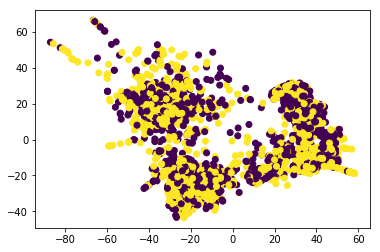

In [23]:
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=Y)

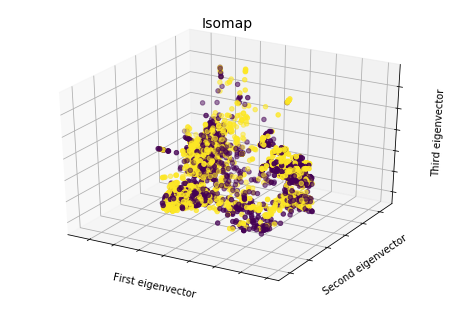

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('Isomap', size=14)
ax.scatter(X_transform[:,0],X_transform[:,1],X_transform[:,2], c=Y)
ax.set_xlabel('First eigenvector')
ax.set_ylabel('Second eigenvector')
ax.set_zlabel('Third eigenvector')
ax.w_xaxis.set_ticklabels(())
ax.w_yaxis.set_ticklabels(())
ax.w_zaxis.set_ticklabels(())
plt.show()

## Descomposición por LLE

In [26]:
t0=time()
for components in [3,5,10,15,20,30,40,50,100,150,200,500]:
    X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = components,
                                        eigen_solver='auto',
                                        method='standard').fit_transform(X)
    kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

    results = []

    for train_index, test_index in kf:
        X_train, X_test = X_transform[train_index], X_transform[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # train a logistic regression model
        logreg = LogisticRegression(C=1e9)
        logreg.fit(X_train, y_train)

        # make predictions for testing set
        y_pred_class = logreg.predict(X_test)

        # calculate testing accuracy
        results.append(log_loss(y_test, y_pred_class))
        
    print('Components',components)
    print('Mean',pd.Series(results).mean())
    print('Std',pd.Series(results).std() )
    print(' ')
t1=time()
print("%s: %.2g sec" % ('LLE', t1 - t0))

Components 3
Mean 14.50287309948719
Std 0.8922688280895555
 
Components 5
Mean 14.41975550654131
Std 0.5538079891940605
 
Components 10
Mean 13.673876825748096
Std 0.9162489092642192
 
Components 15
Mean 13.204217836112045
Std 0.7538671273028287
 
Components 20
Mean 13.047504436215835
Std 1.0057053159440004
 
Components 30
Mean 11.970206216321234
Std 0.6257920404602021
 
Components 40
Mean 11.786047972467758
Std 0.7812758765286679
 
Components 50
Mean 11.288727923388347
Std 0.7920852223197472
 
Components 100
Mean 10.192935321631344
Std 0.8131099117547602
 
Components 150
Mean 9.364264336309212
Std 0.8325628091971526
 
Components 200
Mean 8.858010222670462
Std 0.9105692284537509
 
Components 500
Mean 7.974024576834234
Std 0.9748942514626326
 
LLE: 1.1e+03 sec


Al realizar la descomposición por LLE variando el número de componentes, se puede notar que no hay reducción del Log Loss si la comparamos con la estimación sin utilizar la reducción de la dimensionalidad exceptuando por las 500 componentes, sin embargo esto no mejora significativamente sin tener en cuenta que se sacrifica tiempo de procesamiento. Este método, queda descartado.

In [32]:
X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = 100,
                                        eigen_solver='auto',
                                        method='standard').fit_transform(X)

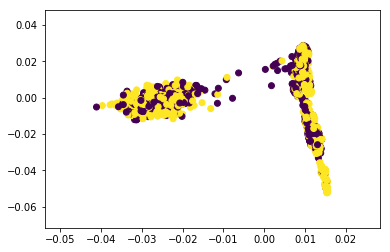

In [33]:
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=Y)

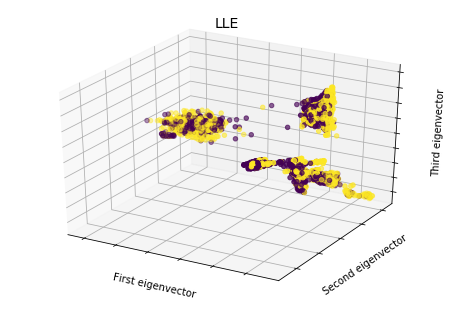

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('LLE', size=14)
ax.scatter(X_transform[:,0],X_transform[:,2],X_transform[:,1], c=Y)
ax.set_xlabel('First eigenvector')
ax.set_ylabel('Second eigenvector')
ax.set_zlabel('Third eigenvector')
ax.w_xaxis.set_ticklabels(())
ax.w_yaxis.set_ticklabels(())
ax.w_zaxis.set_ticklabels(())
plt.show()

## Descomposición por LTSA

In [30]:
from sklearn.cross_validation import KFold

t0=time()
for components in [3,5,10,15,20,30,40,50,100,150,200]:
    
    X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = components,
                                        eigen_solver='dense',
                                        method='ltsa').fit_transform(X)
    kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

    results = []

    for train_index, test_index in kf:
        X_train, X_test = X_transform[train_index], X_transform[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # train a logistic regression model
        logreg = LogisticRegression(C=1e9)
        logreg.fit(X_train, y_train)

        # make predictions for testing set
        y_pred_class = logreg.predict(X_test)

        # calculate testing accuracy
        results.append(log_loss(y_test, y_pred_class))
        
    print('Components',components)
    print('Mean',pd.Series(results).mean())
    print('Std',pd.Series(results).std() )
    print(' ')
t1=time()
print("%s: %.2g sec" % ('LLE', t1 - t0))

Components 3
Mean 15.810601143183373
Std 1.2807566195537505
 
Components 5
Mean 14.907938916367192
Std 0.7375816161262715
 
Components 10
Mean 14.309469151388587
Std 0.8703346920979799
 
Components 15
Mean 13.333314482436402
Std 0.9106780699347826
 
Components 20
Mean 13.913268355697337
Std 0.7398220156192727
 
Components 30
Mean 13.58180193738562
Std 0.8619658801193841
 
Components 40
Mean 12.928041991150701
Std 0.966403731658329
 
Components 50
Mean 11.905953640821453
Std 0.6895281440178642
 
Components 100
Mean 10.460069053052523
Std 0.5913887809953624
 
Components 150
Mean 9.235407748453326
Std 0.541538258787211
 
Components 200
Mean 9.502840988812755
Std 1.1377504812142616
 
LLE: 1.1e+03 sec


Al realizar la descomposición por LTSA variando el número de componentes, se puede notar que no hay reducción del Log Loss si la comparamos con la estimación sin utilizar la reducción de la dimensionalidad. Este método, queda descartado.

In [35]:
X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = 100,
                                        eigen_solver='dense',
                                        method='ltsa').fit_transform(X)

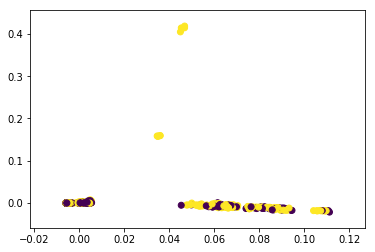

In [37]:
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=Y)

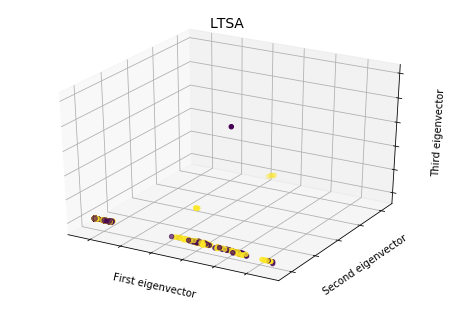

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('LTSA', size=14)
ax.scatter(X_transform[:,0],X_transform[:,1],X_transform[:,2], c=Y)
ax.set_xlabel('First eigenvector')
ax.set_ylabel('Second eigenvector')
ax.set_zlabel('Third eigenvector')
ax.w_xaxis.set_ticklabels(())
ax.w_yaxis.set_ticklabels(())
ax.w_zaxis.set_ticklabels(())
plt.show()

## Descomposición por Modified LLE

In [40]:
t0=time()
for components in [3,5,10,15,20,30,40,50,100,150]:
    X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = components,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(X)
    kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

    results = []

    for train_index, test_index in kf:
        X_train, X_test = X_transform[train_index], X_transform[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # train a logistic regression model
        logreg = LogisticRegression(C=1e9)
        logreg.fit(X_train, y_train)

        # make predictions for testing set
        y_pred_class = logreg.predict(X_test)

        # calculate testing accuracy
        results.append(log_loss(y_test, y_pred_class))
        
    print('Components',components)
    print('Mean',pd.Series(results).mean())
    print('Std',pd.Series(results).std() )
    print(' ')
t1=time()
print("%s: %.2g sec" % ('LLE', t1 - t0))

Components 3
Mean 15.782969482389504
Std 1.301941099521412
 
Components 5
Mean 15.9486403611071
Std 1.1625480734947167
 
Components 10
Mean 14.217227263162695
Std 0.7198271375270713
 
Components 15
Mean 14.806560616740802
Std 0.8083853122793607
 
Components 20
Mean 14.023758775857754
Std 0.741963138507803
 
Components 30
Mean 12.449361161787909
Std 1.0210129298017794
 
Components 40
Mean 11.040295785973674
Std 0.7625960786835605
 
Components 50
Mean 10.81927978763349
Std 0.49853739520189494
 
Components 100
Mean 9.272429106948975
Std 0.7453964651777613
 
Components 150
Mean 8.673825563629967
Std 0.9328089553178784
 
LLE: 1.2e+03 sec


Al realizar la descomposición por MLLE variando el número de componentes, se puede notar que no hay reducción del Log Loss si la comparamos con la estimación sin utilizar la reducción de la dimensionalidad. Este método, queda descartado.

In [42]:
X_transform = manifold.LocallyLinearEmbedding(n_neighbors = 200, n_components = 100,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(X)

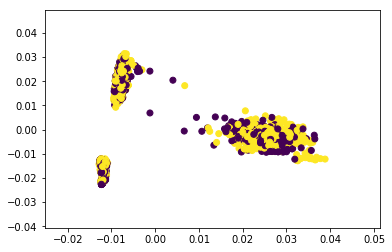

In [44]:
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=Y)

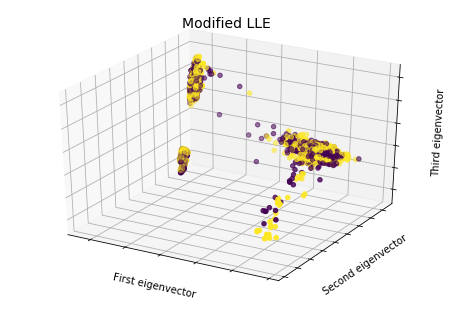

In [45]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('Modified LLE', size=14)
ax.scatter(X_transform[:,0],X_transform[:,2],X_transform[:,1], c=Y)
ax.set_xlabel('First eigenvector')
ax.set_ylabel('Second eigenvector')
ax.set_zlabel('Third eigenvector')
ax.w_xaxis.set_ticklabels(())
ax.w_yaxis.set_ticklabels(())
ax.w_zaxis.set_ticklabels(())
plt.show()

Finalmente, se decide utilizar el primer método de reducción de dimensionalidad, PCA para la calibración y estimación de los modelos.

## Desbalanceo

Antes de proceder con la estimación de los modelos, se hace una verificación de desbalanceo de la base. Se observa que la proporción de 0's y 1's es de 45% y 55%, respectivamente. Aunque la diferencia no es muy grande (5%) se hace una verificación, variando los parámetros del 'target percentage' y utilizando de nuevo el parámetro de log loss para verificar si el desbalanceo podría mejorar la estimación de los parámetros.  

In [46]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(C=1e9)
def SMOTE(X, y, target_percentage=0.5, k=5, seed=None):
    
    # New samples
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()
    n_samples_1_new =  int(-target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1)
    
    # A matrix to store the synthetic samples
    new = np.zeros((n_samples_1_new, X.shape[1]))
    
    # Create seeds
    np.random.seed(seed)
    seeds = np.random.randint(1, 1000000, 3)
    
    # Select examples to use as base
    np.random.seed(seeds[0])
    sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)
    
    # Define random seeds (2 per example)
    np.random.seed(seeds[1])
    nn__ = np.random.choice(k, n_samples_1_new)
    np.random.seed(seeds[2])
    steps = np.random.uniform(size=n_samples_1_new)  

    # For each selected examples create one synthetic case
    for i, sel in enumerate(sel_):
        # Select neighbor
        nn_ = nn__[i]
        step = steps[i]
        # Create new sample
        new[i, :] = X[y==1][sel] - step * (X[y==1][sel] - X[y==1][nn_])
    
    X = np.vstack((X, new))
    y = np.append(y, np.ones(n_samples_1_new))
    
    return X, y

def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Plot the two classes
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100,random_state= 666)
# Fit and transform x to visualise inside a 2D feature space
X_transform = pca.fit_transform(X)

In [48]:
n_samples_0 = (Y == 0).sum()
n_samples_1 = (Y == 1).sum()
n_samples_0/Y.shape[0],n_samples_1/Y.shape[0]

(0.4577446014396161, 0.5422553985603839)

In [49]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=666)
  
X_train_transform = pca.fit_transform(X_train)
X_test_transform = pca.fit_transform(X_test)
X_test_transform.shape,X_train_transform.shape

((938, 100), (2813, 100))

Target percentage 0.6 k  10
y.shape =  3237 y.mean() =  0.5999382143960457
Log loss 18.852910687874566
 


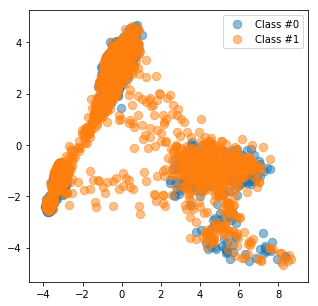

Target percentage 0.7 k  10
y.shape =  4316 y.mean() =  0.6999536607970342
Log loss 18.705602483700368
 


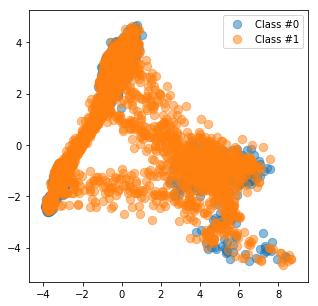

Target percentage 0.8 k  10
y.shape =  6475 y.mean() =  0.8
Log loss 18.963344316957524
 


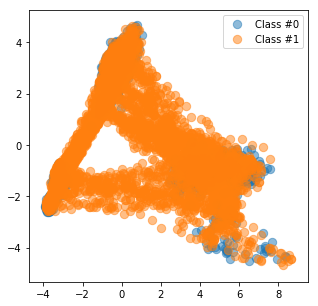

Target percentage 0.9 k  10
y.shape =  12950 y.mean() =  0.9
Log loss 18.374170319261463
 


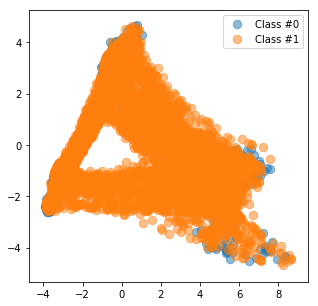

In [51]:
for target_percentage in [0.6, 0.7,0.8,0.9]:
        X_u, y_u = SMOTE(X_train_transform, y_train, target_percentage, 10, seed=66)
        print('Target percentage', target_percentage, 'k ', 10)
        print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
        logreg.fit(X_u,y_u)
        y_pred_class_log = logreg.predict(X_test_transform)
        print('Log loss',log_loss(y_pred_class_log,y_test))
        print(' ')
        plot_two_classes(X_u, y_u, size=(5, 5))
        plt.show()
    

En los gráficos se puede observar que el desbalanceo empeora el objetivo de minimizar el log loss, por ende, no se utiliza desbalanceo para la calibración y estimación de los parámetros.

# Estimación de modelos

Cómo se había mencionado antes, se utilizaron 4 modelos para la estimación de la actividad molecular. 

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

models = {'lr': LogisticRegression(),
          'dt': DecisionTreeClassifier(),
          'nb': GaussianNB(),
          'rf': RandomForestClassifier()}

In [73]:
kf = KFold(X_transform.shape[0], n_folds=10, random_state=666)

results = []

for train_index, test_index in kf:
    X_train, X_test = X_transform[train_index], X_transform[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    for model in models.keys():
        models[model].fit(X_train, y_train) 

        

In [78]:
y_pred = pd.DataFrame(index=X_test, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)  
    

In [75]:
import numpy as np
from sklearn.metrics import mean_squared_error

for model in models.keys():
    print(model,'RMSE',np.sqrt(mean_squared_error(y_pred[model], y_test)))
    print(model, 'Log loss',metrics.log_loss(y_pred[model],y_test))
    print(' ')

lr RMSE 0.5163977794943222
lr Log loss 9.21044911722669
 
dt RMSE 0.570379990298865
dt Log loss 11.236736792620329
 
nb RMSE 0.6653319973266479
nb Log loss 15.289378243461847
 
rf RMSE 0.521536192416212
rf Log loss 9.394672982744723
 


Podemos observar, que el modelo que mejor se ajusta es el Random Forest, ya que minimiza tanto la raiz del error cuadrático medio como el Log Loss. Sin embargo, al realizar el ensamble se observa que el RMSE se minimiza mucho más que sólo seleccionando un modelo.

In [79]:
np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test))

0.4468407620916725

## Conclusiones

* La obtención un modelo muy bien ajustado, con una predicción muy eficaz es muy importante ya que en la aplicación farmacéutica el error debe ser mínimo para garantizar la calidad de posibles productos o la obtención futura de los mismos.

* Es importante analizar el problema a solucionar y entenderlo de gran manera, al igual que las diferentes variables que componen la información del mismo, la opinión de un experto siempre será pertinente para asegurar una estimación de calidad y pronósticos acertados.

* La reducción de la dimensionalidad es una herramienta óptima para mejorar el procesamiento de datos, sin embargo, se debe tener cuidado con saber cuál de los métodos es aplicable y óptimo para el contexto del problema.

* Respecto a los modelos, se encontró que el modelo Random Forest es muy útil para predecir variables binarias y se comportó bien con la distribución de los datos, sin embargo, ensamblar varios modelos ayudó a mejorar el comportamiento del modelo. Esto se debe a que cada modelo se enfoca en dificultades diferentes, y la mezcla de los mismos puede hacer que varias dificultades con la calibración sean tomadas en cuenta para mejorar la eficiencia del modelo.